In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [4]:
import numpy as np

class NeuralNetwork:
    """
    A basic, feedforward neural network class.

    Attributes:
        n_input (int): Number of input features.
        hidden_dims (list): A list of integers, defining the number of neurons in each hidden layer.
        n_output (int): Number of output units.
        learning_rate (float): The learning rate for training.
        n_iters (int): Number of iterations for training.
        weights (list): A list of weight matrices.
        biases (list): A list of bias vectors.
        activation_function (str): The activation function to use (e.g., 'sigmoid', 'relu', 'tanh').
    """

    def __init__(self, n_input, hidden_dims, n_output, learning_rate=0.01, n_iters=1000, activation_function='sigmoid'):
        """
        Initializes the neural network.

        Args:
            n_input (int): Number of input features.
            hidden_dims (list): Number of neurons in each hidden layer.
            n_output (int): Number of output units.
            learning_rate (float, optional): Learning rate. Defaults to 0.01.
            n_iters (int, optional): Number of iterations. Defaults to 1000.
            activation_function (str, optional): Activation function. Defaults to 'sigmoid'.
        """
        self.n_input = n_input
        self.hidden_dims = hidden_dims
        self.n_output = n_output
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = []
        self.biases = []
        self.activation_function = activation_function
        self.activation_functions = {
            'sigmoid': self._sigmoid,
            'relu': self._relu,
            'tanh': self._tanh
        }
        self.derivatives = {  # Store derivatives of activation functions
            'sigmoid': self._sigmoid_derivative,
            'relu': self._relu_derivative,
            'tanh': self._tanh_derivative
        }

        # Initialize weights and biases
        self._initialize_weights()

    def _initialize_weights(self):
        """
        Initializes the weights and biases of the network.
        """
        # Input layer to the first hidden layer
        self.weights.append(np.random.randn(self.n_input, self.hidden_dims[0]) * 0.01)  # Small random values
        self.biases.append(np.zeros(self.hidden_dims[0]))

        # Hidden layers to subsequent hidden layers
        for i in range(len(self.hidden_dims) - 1):
            self.weights.append(np.random.randn(self.hidden_dims[i], self.hidden_dims[i+1]) * 0.01)
            self.biases.append(np.zeros(self.hidden_dims[i+1]))

        # Last hidden layer to the output layer
        self.weights.append(np.random.randn(self.hidden_dims[-1], self.n_output) * 0.01)
        self.biases.append(np.zeros(self.n_output))

    def fit(self, X, y):
        """
        Trains the neural network on the given data using backpropagation.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): Target values, shape (n_samples,).
        """
        n_samples = X.shape[0]
        y = y.reshape(-1, 1)  # Ensure y has the correct shape (n_samples, 1)

        for _ in range(self.n_iters):
            # Forward pass
            activations = self._forward_pass(X)

            # Backward pass
            gradients = self._backward_pass(X, y, activations)

            # Update parameters
            self._update_parameters(gradients)

    def predict(self, X):
        """
        Predicts the output for the given data.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).

        Returns:
            ndarray: Predicted values, shape (n_samples,).
        """
        activations = self._forward_pass(X)
        return activations[-1]  # The last activation is the output

    def _sigmoid(self, x):
        """
        Computes the sigmoid function.

        Args:
            x (ndarray): Input values.

        Returns:
            ndarray: Sigmoid of x.
        """
        return 1 / (1 + np.exp(-x))
    
    def _sigmoid_derivative(self, x):
        """
        Computes the derivative of the sigmoid function.

        Args:
            x (ndarray): Input values (pre-activation).

        Returns:
            ndarray: Derivative of sigmoid.
        """
        s = self._sigmoid(x)
        return s * (1 - s)

    def _relu(self, x):
        """
        Computes the ReLU function.

        Args:
            x (ndarray): Input values.

        Returns:
            ndarray: ReLU of x.
        """
        return np.maximum(0, x)
    
    def _relu_derivative(self, x):
        """
        Computes the derivative of the ReLU function.

        Args:
            x (ndarray): Input values (pre-activation).

        Returns:
            ndarray: Derivative of ReLU.
        """
        return np.where(x > 0, 1, 0)

    def _tanh(self, x):
        """
        Computes the tanh function.

        Args:
            x (ndarray): Input values.

        Returns:
            ndarray: tanh of x.
        """
        return np.tanh(x)
    
    def _tanh_derivative(self, x):
        """
        Computes the derivative of the tanh function.

        Args:
            x (ndarray): Input values (pre-activation).

        Returns:
            ndarray: Derivative of tanh.
        """
        return 1 - np.tanh(x)**2

    def _forward_pass(self, X):
        """
        Performs a forward pass through the network.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).

        Returns:
            list: A list of activations at each layer.
        """
        activations = [X]  # Start with the input
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            activation_function = self.activation_functions[self.activation_function]
            a = activation_function(z)
            activations.append(a)
        return activations

    def _backward_pass(self, X, y, activations):
        """
        Performs backpropagation to compute gradients.

        Args:
            X (ndarray): Input features, shape (n_samples, n_features).
            y (ndarray): Target values, shape (n_samples,).
            activations (list): Activations from the forward pass.

        Returns:
            list: A list of gradients for weights and biases.
        """
        gradients_w = []
        gradients_b = []
        n_samples = X.shape[0]

        # Output layer
        error = activations[-1] - y  # (n_samples, n_output)
        derivative_func = self.derivatives[self.activation_function] #get derivative function
        dz = error * derivative_func(np.dot(activations[-2], self.weights[-1]) + self.biases[-1])  # (n_samples, n_output)
        
        dw = (1 / n_samples) * np.dot(activations[-2].T, dz)  # (hidden_dims[-1], n_output)
        db = (1 / n_samples) * np.sum(dz, axis=0)  # (n_output,)
        
        gradients_w.insert(0, dw)
        gradients_b.insert(0, db)

        # Hidden layers (from last to first)
        for i in range(len(self.weights) - 2, -1, -1):
            dz = np.dot(dz, self.weights[i+1].T) * self.derivatives[self.activation_function](np.dot(activations[i], self.weights[i]) + self.biases[i])  # (n_samples, hidden_dims[i])
            dw = (1 / n_samples) * np.dot(activations[i].T, dz)  # (hidden_dims[i-1], hidden_dims[i]) or (n_features, hidden_dims[0])
            db = (1 / n_samples) * np.sum(dz, axis=0)  # (hidden_dims[i],)
            
            gradients_w.insert(0, dw)
            gradients_b.insert(0, db)

        return gradients_w, gradients_b

    def _update_parameters(self, gradients):
        """
        Updates the weights and biases based on the computed gradients.

        Args:
            gradients (tuple): A tuple containing lists of gradients for weights and biases.
        """
        gradients_w, gradients_b = gradients
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * gradients_w[i]
            self.biases[i] -= self.learning_rate * gradients_b[i]

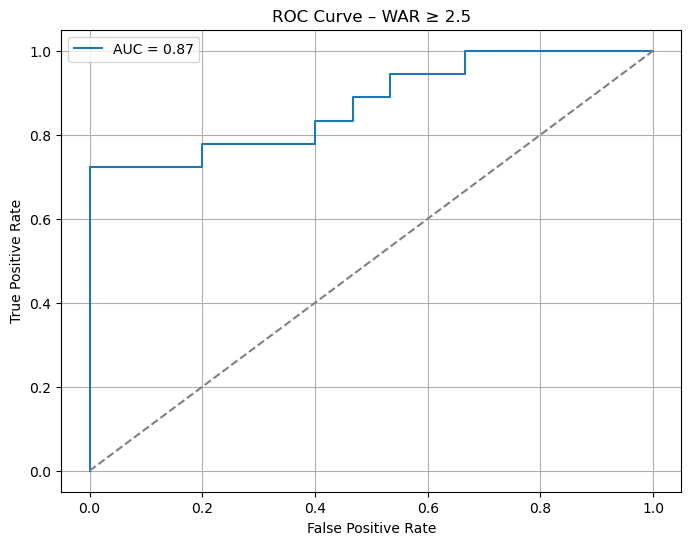

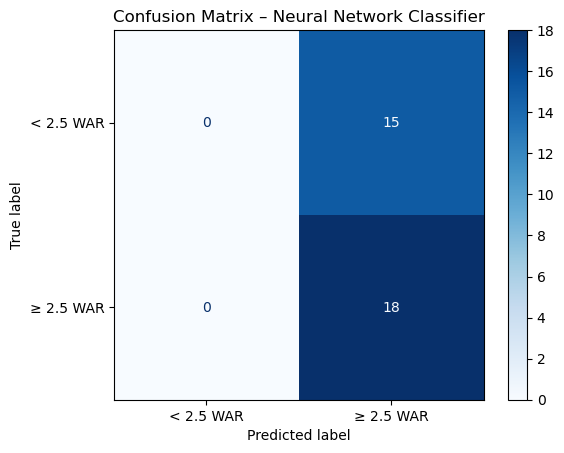

In [8]:
# Load the data
df = pd.read_csv("cleaned_mlb_2022_full.csv")

# Create binary target for WAR >= 2.5
df["High_WAR"] = (df["WAR"] >= 2.5).astype(int)

# Select numeric features and clean
df_clean = df.drop(columns=["Name", "Team", "WAR", "High_WAR", "Season", "IDfg"], errors='ignore')
df_clean = df_clean.select_dtypes(include=[np.number]).copy()
df_clean = df_clean.fillna(df_clean.mean())

X = df_clean.values
y = df["High_WAR"].values

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# Initialize and train neural network
nn = NeuralNetwork(
    n_input=X_train.shape[1],
    hidden_dims=[16, 8],
    n_output=1,
    learning_rate=0.01,
    n_iters=1000,
    activation_function="sigmoid"
)
nn.fit(X_train, y_train)

# Predict
y_probs = nn.predict(X_test).ravel()
y_preds = (y_probs >= 0.5).astype(int)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – WAR ≥ 2.5")
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["< 2.5 WAR", "≥ 2.5 WAR"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Neural Network Classifier")
plt.grid(False)
plt.show()

The ROC curve demonstrates strong classification performance by the neural network. With an AUC of 0.87, the model is effectively separating players with WAR greater than or equal to 2.5 from those who fall below that threshold. The curve rises sharply toward the upper-left corner, indicating a high true positive rate even at low false positive rates. This suggests that the model is well-calibrated and has learned meaningful relationships between the input features and the likelihood of a player being a mid-to-high value contributor. The smoother curve and high AUC score reflect a better balance in class distribution compared to more extreme thresholds and show the network is capturing non-linear patterns in the data.

The confusion matrix reveals that the classifier predicted every player as having WAR greater than or equal to 2.5. As a result, all 18 actual high-WAR players were correctly classified (true positives), but the model also misclassified all 15 low-WAR players as high-WAR (false positives). While the recall is perfect, the lack of any true negatives points to a tradeoff in precision. This could be due to the decision threshold (default 0.5) not being optimal, or the model being overconfident in positive predictions. Tuning the classification threshold or regularizing the model might help improve its ability to distinguish more marginal contributors without sacrificing recall.